In [6]:
# !pip install pandas numpy matplotlib seaborn scikit-learn

In [7]:
# !pip freeze > requirements.txt

In [8]:
# !pip install -r requirements.txt

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [10]:
# Generate sample loan approval data
np.random.seed(42)
n_samples = 1000

data = {
    'Loan_ID': [f'LP{str(i).zfill(6)}' for i in range(1, n_samples + 1)],
    'Gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.6, 0.4]),
    'Married': np.random.choice(['Yes', 'No'], n_samples, p=[0.7, 0.3]),
    'Dependents': np.random.choice(['0', '1', '2', '3+'], n_samples, p=[0.4, 0.3, 0.2, 0.1]),
    'Education': np.random.choice(['Graduate', 'Not Graduate'], n_samples, p=[0.8, 0.2]),
    'Self_Employed': np.random.choice(['Yes', 'No'], n_samples, p=[0.15, 0.85]),
    'ApplicantIncome': np.random.normal(5000, 2000, n_samples).astype(int),
    'CoapplicantIncome': np.random.exponential(1500, n_samples).astype(int),
    'LoanAmount': np.random.normal(150, 50, n_samples).astype(int),
    'Loan_Amount_Term': np.random.choice([360, 180, 240, 300], n_samples, p=[0.8, 0.1, 0.05, 0.05]),
    'Credit_History': np.random.choice([1.0, 0.0], n_samples, p=[0.85, 0.15]),
    'Property_Area': np.random.choice(['Urban', 'Semiurban', 'Rural'], n_samples, p=[0.4, 0.35, 0.25])
}

# Create loan status based on some logic
loan_status = []
for i in range(n_samples):
    score = 0
    if data['Credit_History'][i] == 1.0:
        score += 3
    if data['Education'][i] == 'Graduate':
        score += 1
    if data['Married'][i] == 'Yes':
        score += 1
    if data['ApplicantIncome'][i] > 4000:
        score += 1
    if data['LoanAmount'][i] < 200:
        score += 1
    
    # Add some randomness
    if np.random.random() < 0.1:
        score = np.random.randint(0, 6)
    
    loan_status.append('Y' if score >= 3 else 'N')

data['Loan_Status'] = loan_status

# Create DataFrame
df = pd.DataFrame(data)

# Introduce some missing values
missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
df.loc[missing_indices[:len(missing_indices)//3], 'Gender'] = np.nan
df.loc[missing_indices[len(missing_indices)//3:2*len(missing_indices)//3], 'LoanAmount'] = np.nan
df.loc[missing_indices[2*len(missing_indices)//3:], 'Credit_History'] = np.nan

print(f"Dataset created with {len(df)} rows and {len(df.columns)} columns")
df.head()

Dataset created with 1000 rows and 13 columns


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP000001,Male,Yes,0,Graduate,No,3806,101,142.0,360,1.0,Semiurban,Y
1,LP000002,Female,Yes,0,Graduate,No,219,1195,152.0,360,1.0,Semiurban,Y
2,LP000003,Female,No,3+,Graduate,No,4175,1340,201.0,360,1.0,Urban,Y
3,LP000004,Male,No,0,Graduate,No,6826,1586,140.0,360,1.0,Rural,Y
4,LP000005,Male,No,0,Graduate,Yes,6075,442,121.0,360,1.0,Urban,Y


In [11]:
print("Dataset Shape:", df.shape)
print("\nColumn Information:")
df.info()

Dataset Shape: (1000, 13)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            1000 non-null   object 
 1   Gender             984 non-null    object 
 2   Married            1000 non-null   object 
 3   Dependents         1000 non-null   object 
 4   Education          1000 non-null   object 
 5   Self_Employed      1000 non-null   object 
 6   ApplicantIncome    1000 non-null   int64  
 7   CoapplicantIncome  1000 non-null   int64  
 8   LoanAmount         983 non-null    float64
 9   Loan_Amount_Term   1000 non-null   int64  
 10  Credit_History     983 non-null    float64
 11  Property_Area      1000 non-null   object 
 12  Loan_Status        1000 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 101.7+ KB


In [12]:
print("Missing Values:")
print(df.isnull().sum())
print(f"\nMissing Values Percentage:")
print((df.isnull().sum() / len(df) * 100).round(2))

Missing Values:
Loan_ID               0
Gender               16
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           17
Loan_Amount_Term      0
Credit_History       17
Property_Area         0
Loan_Status           0
dtype: int64

Missing Values Percentage:
Loan_ID              0.0
Gender               1.6
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           1.7
Loan_Amount_Term     0.0
Credit_History       1.7
Property_Area        0.0
Loan_Status          0.0
dtype: float64


In [13]:
print("Numerical Features Statistics:")
df.describe()

Numerical Features Statistics:


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,1000.000000,1000.000000,983.000000,1000.000000,983.000000
mean,4895.798000,1473.488000,147.715158,333.120000,0.861648
std,1998.877777,1430.316416,50.920891,59.101257,0.345445
min,-1353.000000,0.000000,5.000000,180.000000,0.000000
25%,3634.500000,432.000000,113.000000,360.000000,1.000000
50%,4975.500000,999.000000,147.000000,360.000000,1.000000
75%,6266.250000,2126.500000,184.000000,360.000000,1.000000
max,11304.000000,10710.000000,304.000000,360.000000,1.000000


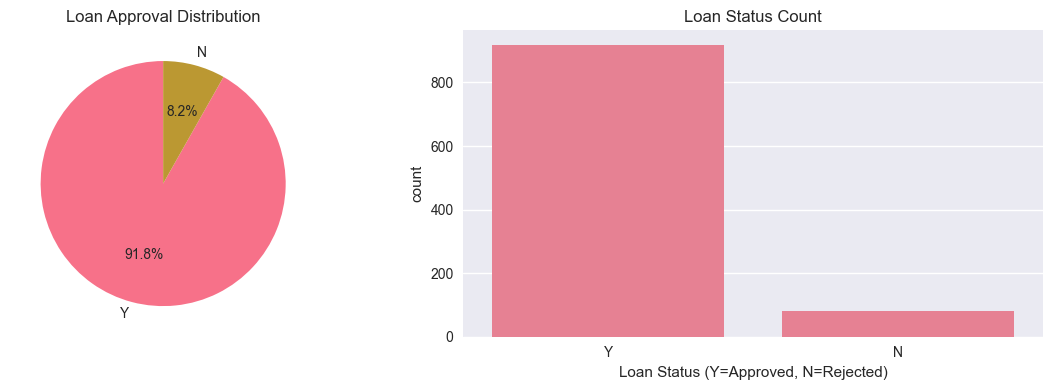

Loan Approval Rate: 91.80%


In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
loan_counts = df['Loan_Status'].value_counts()
plt.pie(loan_counts.values, labels=loan_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Loan Approval Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Loan_Status')
plt.title('Loan Status Count')
plt.xlabel('Loan Status (Y=Approved, N=Rejected)')

plt.tight_layout()
plt.show()

print(f"Loan Approval Rate: {(df['Loan_Status'] == 'Y').mean():.2%}")

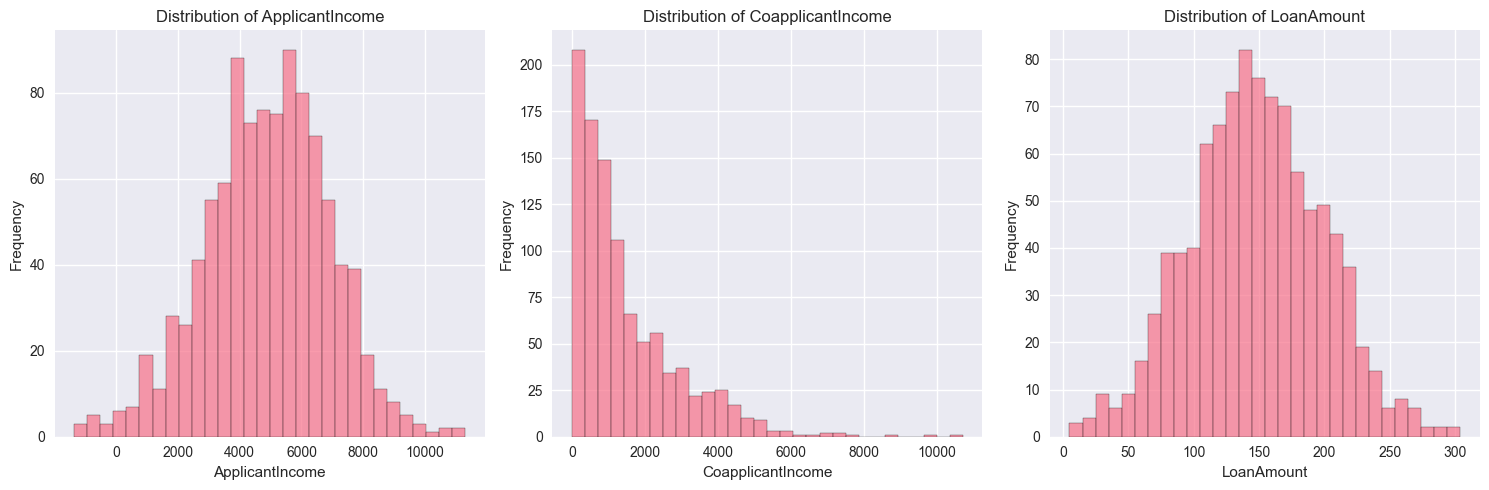

In [15]:
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

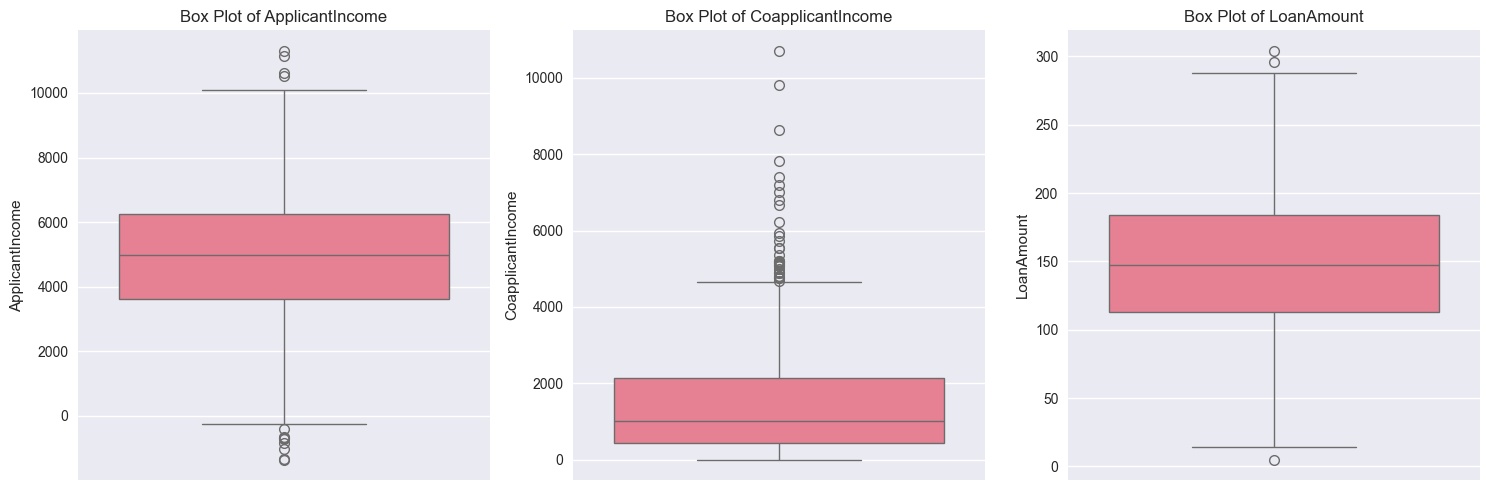

In [16]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

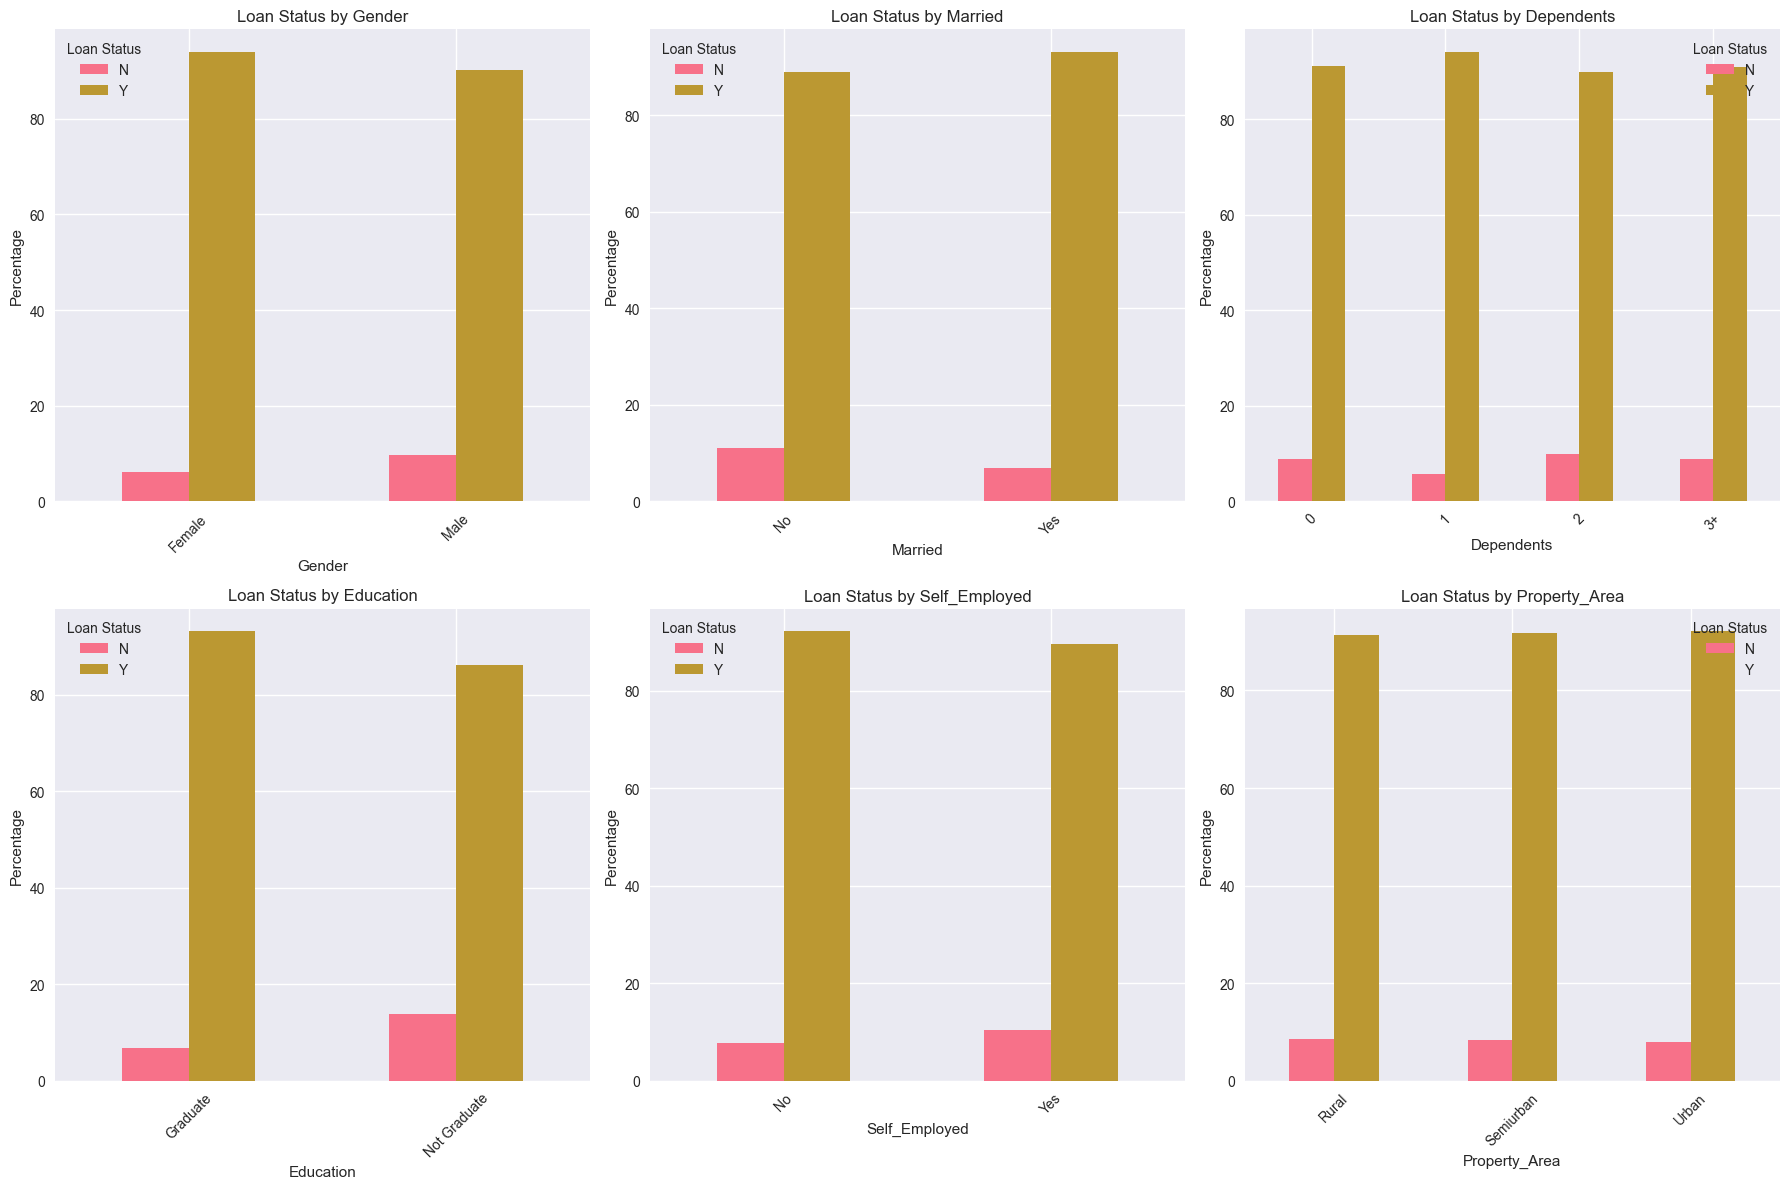

In [17]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    crosstab = pd.crosstab(df[col], df['Loan_Status'], normalize='index') * 100
    crosstab.plot(kind='bar', ax=plt.gca())
    plt.title(f'Loan Status by {col}')
    plt.xlabel(col)
    plt.ylabel('Percentage')
    plt.legend(title='Loan Status')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Create a copy for preprocessing
df_model = df.copy()

# Handle missing values
df_model['Gender'].fillna(df_model['Gender'].mode()[0], inplace=True)
df_model['LoanAmount'].fillna(df_model['LoanAmount'].median(), inplace=True)
df_model['Credit_History'].fillna(df_model['Credit_History'].mode()[0], inplace=True)

print("Missing values after preprocessing:")
print(df_model.isnull().sum())

print("Shape after preprocessing:")
print(df_model.shape)

Missing values after preprocessing:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Shape after preprocessing:
(1000, 13)


In [20]:
# Feature engineering
df_model['TotalIncome'] = df_model['ApplicantIncome'] + df_model['CoapplicantIncome']
df_model['Income_to_Loan_Ratio'] = df_model['TotalIncome'] / df_model['LoanAmount']

# Log transformation for skewed features
df_model['ApplicantIncome_log'] = np.log1p(df_model['ApplicantIncome'])
df_model['TotalIncome_log'] = np.log1p(df_model['TotalIncome'])

print("New features created:")
print(df_model[['TotalIncome', 'Income_to_Loan_Ratio', 'ApplicantIncome_log', 'TotalIncome_log']].head())

New features created:
   TotalIncome  Income_to_Loan_Ratio  ApplicantIncome_log  TotalIncome_log
0         3907             27.514085             8.244597         8.270781
1         1414              9.302632             5.393628         7.254885
2         5515             27.437811             8.337109         8.615408
3         8412             60.085714             8.828641         9.037533
4         6517             53.859504             8.712102         8.782323


In [21]:
# Label encoding for categorical variables
label_encoders = {}
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for feature in categorical_features:
    le = LabelEncoder()
    df_model[feature + '_encoded'] = le.fit_transform(df_model[feature])
    label_encoders[feature] = le

# Encode target variable
target_encoder = LabelEncoder()
df_model['Loan_Status_encoded'] = target_encoder.fit_transform(df_model['Loan_Status'])

print("Encoded features:")
encoded_cols = [col for col in df_model.columns if col.endswith('_encoded')]
print(df_model[encoded_cols].head())

Encoded features:
   Gender_encoded  Married_encoded  Dependents_encoded  Education_encoded  \
0               1                1                   0                  0   
1               0                1                   0                  0   
2               0                0                   3                  0   
3               1                0                   0                  0   
4               1                0                   0                  0   

   Self_Employed_encoded  Property_Area_encoded  Loan_Status_encoded  
0                      0                      1                    1  
1                      0                      1                    1  
2                      0                      2                    1  
3                      0                      0                    1  
4                      1                      2                    1  


In [22]:
feature_columns = [
    'Gender_encoded', 'Married_encoded', 'Dependents_encoded', 'Education_encoded',
    'Self_Employed_encoded', 'Property_Area_encoded', 'ApplicantIncome', 'CoapplicantIncome',
    'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'Income_to_Loan_Ratio',
    'ApplicantIncome_log', 'TotalIncome_log'
]

X = df_model[feature_columns]
y = df_model['Loan_Status_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {feature_columns}")

Feature matrix shape: (1000, 15)
Target vector shape: (1000,)

Features used: ['Gender_encoded', 'Married_encoded', 'Dependents_encoded', 'Education_encoded', 'Self_Employed_encoded', 'Property_Area_encoded', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'Income_to_Loan_Ratio', 'ApplicantIncome_log', 'TotalIncome_log']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Training
